In [1]:
import os, sys
import numpy as np
import pandas as pd
from numpy.random import multinomial
import EMdata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
import itertools
import random, math
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
import time

# Loading Data

In [2]:
#GPU or CPU
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"  
device = torch.device(dev) 

In [3]:
#data path
file_path='F:/script/class2vec/real_star_file/10640_polished_noig.star'
datatype=0 #0 is relion 3.1, 1 is relion 3, 2 is cryosparc

file_name=os.path.basename(file_path)
output_path=os.path.dirname(file_path)+'/'+os.path.splitext(file_name)[0]
if os.path.isdir(output_path) is False:
    os.mkdir(output_path)

In [4]:
# parameters
#window size
#w = 4

#ignore classes
#ignore_classes=[3,13,15,44,23,7,22,26,14,28,18,38,47,48,11,35,37]
#ignore_classes=[1,2,3,5,8,10,14,15,17,18,19,21,22,23,24,27,28,31,32,33,34,35,37,38,40,41,44] #GSS20173_300
#ignore_classes=[1,6,7,8,16,17,19,20,21,24,36,38,46] 
#ignore_classes=[14] #10243_tau
#ignore_classes=[2,3,4,11,12,19,20,25,33,36,37,40,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig
#ignore_classes=[2,3,4,11,12,13,19,20,25,33,36,37,40,42,43,44,45,46,47,48,49,50] #10340_Case2_tau_ig by observe
#ignore_classes=[2,5,6,7,12,16,19,23,24,25,30,31,32,33,39,44,45,50] #10340_Case2_tau_ig_E8
#ignore_classes=[]

In [5]:
if datatype<2:
    file_info=EMdata.read_relion(file_path)
    if datatype==0:
        #read data (relion3.1)
        dataset=file_info.getRdata_31()
        optics=file_info.extractoptic()
    else:
        #read relion 3.0
        dataset=file_info.getRdata()
    metadata=dataset[0]
    print(metadata)
    data=dataset[1]
    print(data[0])
    corpus_information=EMdata.process_helical(dataset).extarct_helical_select()
else:
    #read cryosparc
    dataset=np.load(file_path)
    corpus_information=EMdata.process_cryosparc_helical(dataset).extract_helical()
corpus_dic,helix_name=corpus_information
corpus=list(corpus_dic.values())
corpus_backup=corpus[:]

['_rlnCoordinateX', '_rlnCoordinateY', '_rlnHelicalTubeID', '_rlnAngleTiltPrior', '_rlnAnglePsiPrior', '_rlnHelicalTrackLengthAngst', '_rlnAnglePsiFlipRatio', '_rlnAngleRotFlipRatio', '_rlnImageName', '_rlnMicrographName', '_rlnOpticsGroup', '_rlnCtfMaxResolution', '_rlnCtfFigureOfMerit', '_rlnDefocusU', '_rlnDefocusV', '_rlnDefocusAngle', '_rlnCtfBfactor', '_rlnCtfScalefactor', '_rlnPhaseShift', '_rlnAngleRot', '_rlnAngleTilt', '_rlnAnglePsi', '_rlnOriginXAngst', '_rlnOriginYAngst', '_rlnClassNumber', '_rlnNormCorrection', '_rlnLogLikeliContribution', '_rlnMaxValueProbDistribution', '_rlnNrOfSignificantSamples', '_rlnRandomSubset', '_rlnGroupNumber']
['1100.074707', '3219.894166', '4', '90.000000', '-125.49979', '0.000000', '0.500000', '0.500000', '000001@Extract/job007/Tiff/FoilHole_28302842_Data_28303584_28303586_20200428_151848-187515.mrcs', 'MotionCorr/job002/Tiff/FoilHole_28302842_Data_28303584_28303586_20200428_151848-187515.mrc', '1', '3.674637', '0.214923', '27341.296079', '27

In [6]:
corpus_ignore=[]
for i in range(len(corpus)):
    corpus_row=[]
    lst=corpus[i]
    count=lst[0][1]
    for j in range(len(lst)):
        particle=lst[j]
        if count==int(particle[1]):
            corpus_row.append(particle[0])
            count+=1
        else:
            while 1:
                if count==int(lst[j][1]):
                    corpus_row.append(particle[0])
                    count+=1
                    break
                corpus_row+=[0]
                count+=1               
    corpus_ignore.append(corpus_row)

In [7]:
print(len(helix_name))

16727


<BarContainer object of 16727 artists>

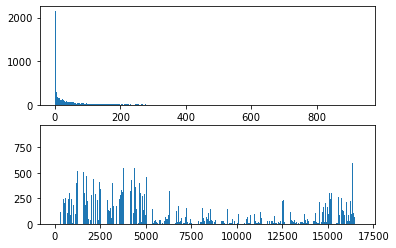

In [8]:
corpus_length_histogram=[]
for i in range(len(corpus_ignore)):
    corpus_length_histogram.append(len(corpus_ignore[i]))
fig,ax=plt.subplots(2)
ax[0].hist(corpus_length_histogram,list(range(0,max(corpus_length_histogram)+10,1)))
ax[1].bar(list(range(0,len(corpus_backup))),corpus_length_histogram)
#plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"length_histogram.png",bbox_inches='tight', pad_inches=0.01)

# Pre-processing

In [9]:
#k-mer seperation
def overlaping_kmer(data,k):
    kmer_corpus=[]
    for i in range(len(data)):
        lst=data[i]
        kmer_lst=[]
        for j in range(len(lst)-k+1):
            kmer_lst.append(str(lst[j])+'-'+str(lst[j+1]))
        kmer_corpus.append(kmer_lst)
    return kmer_corpus

In [10]:
def cut_corpus(corpus,cut_length):
    new_corpus=[]
    cut_length=cut_length
    print(len(corpus))
    for i in range(len(corpus)):
        lst=corpus[i]
        n=len(lst)
        if n<cut_length:
            new_corpus.append(lst)
            continue
        cut_amount=int((n-n%cut_length)/cut_length)
        for j in range(cut_amount-1):
            new_corpus.append(lst[j*cut_length:(j+1)*cut_length])
        new_corpus.append(lst[(cut_amount-1)*cut_length:])
    print(len(new_corpus))
    return new_corpus

In [11]:
#corpus=overlaping_kmer(corpus_backup,2)
#corpus_context=corpus[:]

In [12]:
vocabulary = set(itertools.chain.from_iterable(corpus_ignore))
vocabulary_size = len(vocabulary)
print(vocabulary_size)

65


In [13]:
word_to_index = {w: idx for (idx, w) in enumerate(vocabulary)}
index_to_word = {idx: w for (idx, w) in enumerate(vocabulary)}

In [14]:
#corpus=cut_corpus(corpus_backup,60)
#corpus_context=corpus_backup[:]

In [15]:
def sample_negative(sample_size):
    sample_probability = {}
    word_counts = dict(Counter(list(itertools.chain.from_iterable(corpus_ignore))))
    normalizing = sum([v**0.75 for v in word_counts.values()])
    for word in word_counts:
        sample_probability[word] = word_counts[word]**0.75 / normalizing
    words = np.array(list(word_counts.keys()))
    while True:
        word_list = []
        sampled_index = np.array(multinomial(sample_size, list(sample_probability.values())))
        for index, count in enumerate(sampled_index):
            for _ in range(count):
                 word_list.append(words[index])
        yield word_list

In [16]:
# convert to windoes vector
w = 1
context_tuple_list = []
negative_samples = sample_negative(4)

for text in corpus_ignore:
    for i, word in enumerate(text):
        if word==0:
            continue
        first_context_word_index = max(0,i-w)
        last_context_word_index = min(i+w, len(text))
        for j in range(first_context_word_index, last_context_word_index):
            neighbor=text[j]
            if j==0:
                continue
            if neighbor==0:
                continue
            if i!=j:
                context_tuple_list.append((word, neighbor, next(negative_samples)))
print("There are {} pairs of target and context words".format(len(context_tuple_list)))

There are 223954 pairs of target and context words


# Word2vec

In [17]:
def get_batches(context_tuple_list, batch_size=100):
    random.shuffle(context_tuple_list)
    batches = []
    batch_target, batch_context, batch_negative = [], [], []
    for i in range(len(context_tuple_list)):
        batch_target.append(word_to_index[context_tuple_list[i][0]])
        batch_context.append(word_to_index[context_tuple_list[i][1]])
        batch_negative.append([word_to_index[w] for w in context_tuple_list[i][2]])
        if (i+1) % batch_size == 0 or i == len(context_tuple_list)-1:
            tensor_target = torch.from_numpy(np.array(batch_target)).long().to(device)
            tensor_context = torch.from_numpy(np.array(batch_context)).long().to(device)
            tensor_negative = torch.from_numpy(np.array(batch_negative)).long().to(device)
            batches.append((tensor_target, tensor_context, tensor_negative))
            batch_target, batch_context, batch_negative = [], [], []
    return batches

In [18]:
class Word2Vec(nn.Module):

    def __init__(self, embedding_size, vocab_size):
        super(Word2Vec, self).__init__()
        self.target = nn.Embedding(vocab_size, embedding_size).cuda()
        self.context = nn.Embedding(vocab_size, embedding_size).cuda()

    def forward(self, target_word, context_word, negative_example):
        emb_target = self.target(target_word)
        emb_context = self.context(context_word)
        emb_product = torch.mul(emb_target, emb_context).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out = torch.sum(F.logsigmoid(emb_product)).cuda()
        emb_negative = self.context(negative_example)
        emb_product = torch.bmm(emb_negative, emb_target.unsqueeze(2)).cuda()
        emb_product = torch.sum(emb_product, dim=1).cuda()
        out += torch.sum(F.logsigmoid(-emb_product)).cuda()
        return -out

In [19]:
class EarlyStopping():
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        print("Loss gain: {}%".format(gain*100))
        if gain < self.min_gain:
            return True
        else:
            return False
        

In [20]:
embedding_size=100
loss_function = nn.CrossEntropyLoss()
net = Word2Vec(embedding_size=embedding_size, vocab_size=vocabulary_size)
optimizer = optim.Adam(net.parameters())
early_stopping = EarlyStopping(patience=5, min_percent_gain=1)
n=0
while True:
    n=n+1
    print(n)
    losses = []
    context_tuple_batches = get_batches(context_tuple_list, batch_size=1000)
    for i in range(len(context_tuple_batches)):
        net.zero_grad()
        target_tensor, context_tensor, negative_tensor = context_tuple_batches[i]
        loss = net(target_tensor, context_tensor, negative_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.data)
    print("Loss: ", torch.mean(torch.stack(losses)),torch.stack(losses)[0],torch.stack(losses)[-1])
    early_stopping.update_loss(torch.mean(torch.stack(losses)))
    if early_stopping.stop() is True:
        break
    if torch.mean(torch.stack(losses))<10:
        break

1
Loss:  tensor(9490.8936, device='cuda:0') tensor(21614.0312, device='cuda:0') tensor(3843.6165, device='cuda:0')
2
Loss:  tensor(2147.4412, device='cuda:0') tensor(3297.8008, device='cuda:0') tensor(1404.0112, device='cuda:0')
Loss gain: 77.37366485595703%
3
Loss:  tensor(1165.7356, device='cuda:0') tensor(1440.3101, device='cuda:0') tensor(1101.5964, device='cuda:0')
Loss gain: 87.71733093261719%
4
Loss:  tensor(803.0793, device='cuda:0') tensor(1072.8491, device='cuda:0') tensor(737.5285, device='cuda:0')
Loss gain: 91.53842163085938%
5
Loss:  tensor(613.0771, device='cuda:0') tensor(666.8588, device='cuda:0') tensor(539.0972, device='cuda:0')
Loss gain: 93.54036712646484%
6
Loss:  tensor(507.3065, device='cuda:0') tensor(562.4458, device='cuda:0') tensor(438.4678, device='cuda:0')
Loss gain: 76.37623596191406%
7
Loss:  tensor(438.5220, device='cuda:0') tensor(505.9816, device='cuda:0') tensor(371.8353, device='cuda:0')
Loss gain: 62.382381439208984%
8
Loss:  tensor(390.5624, devic

In [21]:
print(context_tuple_list[0])

(77, 93, [0, 0, 42, 43])


# Show 2D class embedding

In [22]:
import umap
import sklearn
from sklearn.cluster import KMeans,SpectralClustering,MeanShift, estimate_bandwidth,AgglomerativeClustering, DBSCAN
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from scipy.stats import multivariate_normal 
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches

EMBEDDINGS.shape:  (65, 100)
1
2
3
4
5


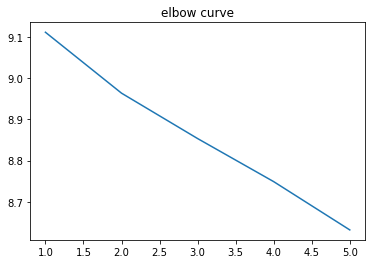

In [23]:
EMBEDDINGS = net.target.weight.data.cpu().numpy()
print('EMBEDDINGS.shape: ', EMBEDDINGS.shape)

res = []
n_cluster = range(1,6)
for n in n_cluster:
    print(n)
    kmeans = KMeans(n_clusters=n)
    kmeans.fit(EMBEDDINGS)
    res.append(np.average(np.min(cdist(EMBEDDINGS, kmeans.cluster_centers_, 'euclidean'), axis=1)))
        
plt.plot(n_cluster, res)
plt.title('elbow curve')
plt.show()

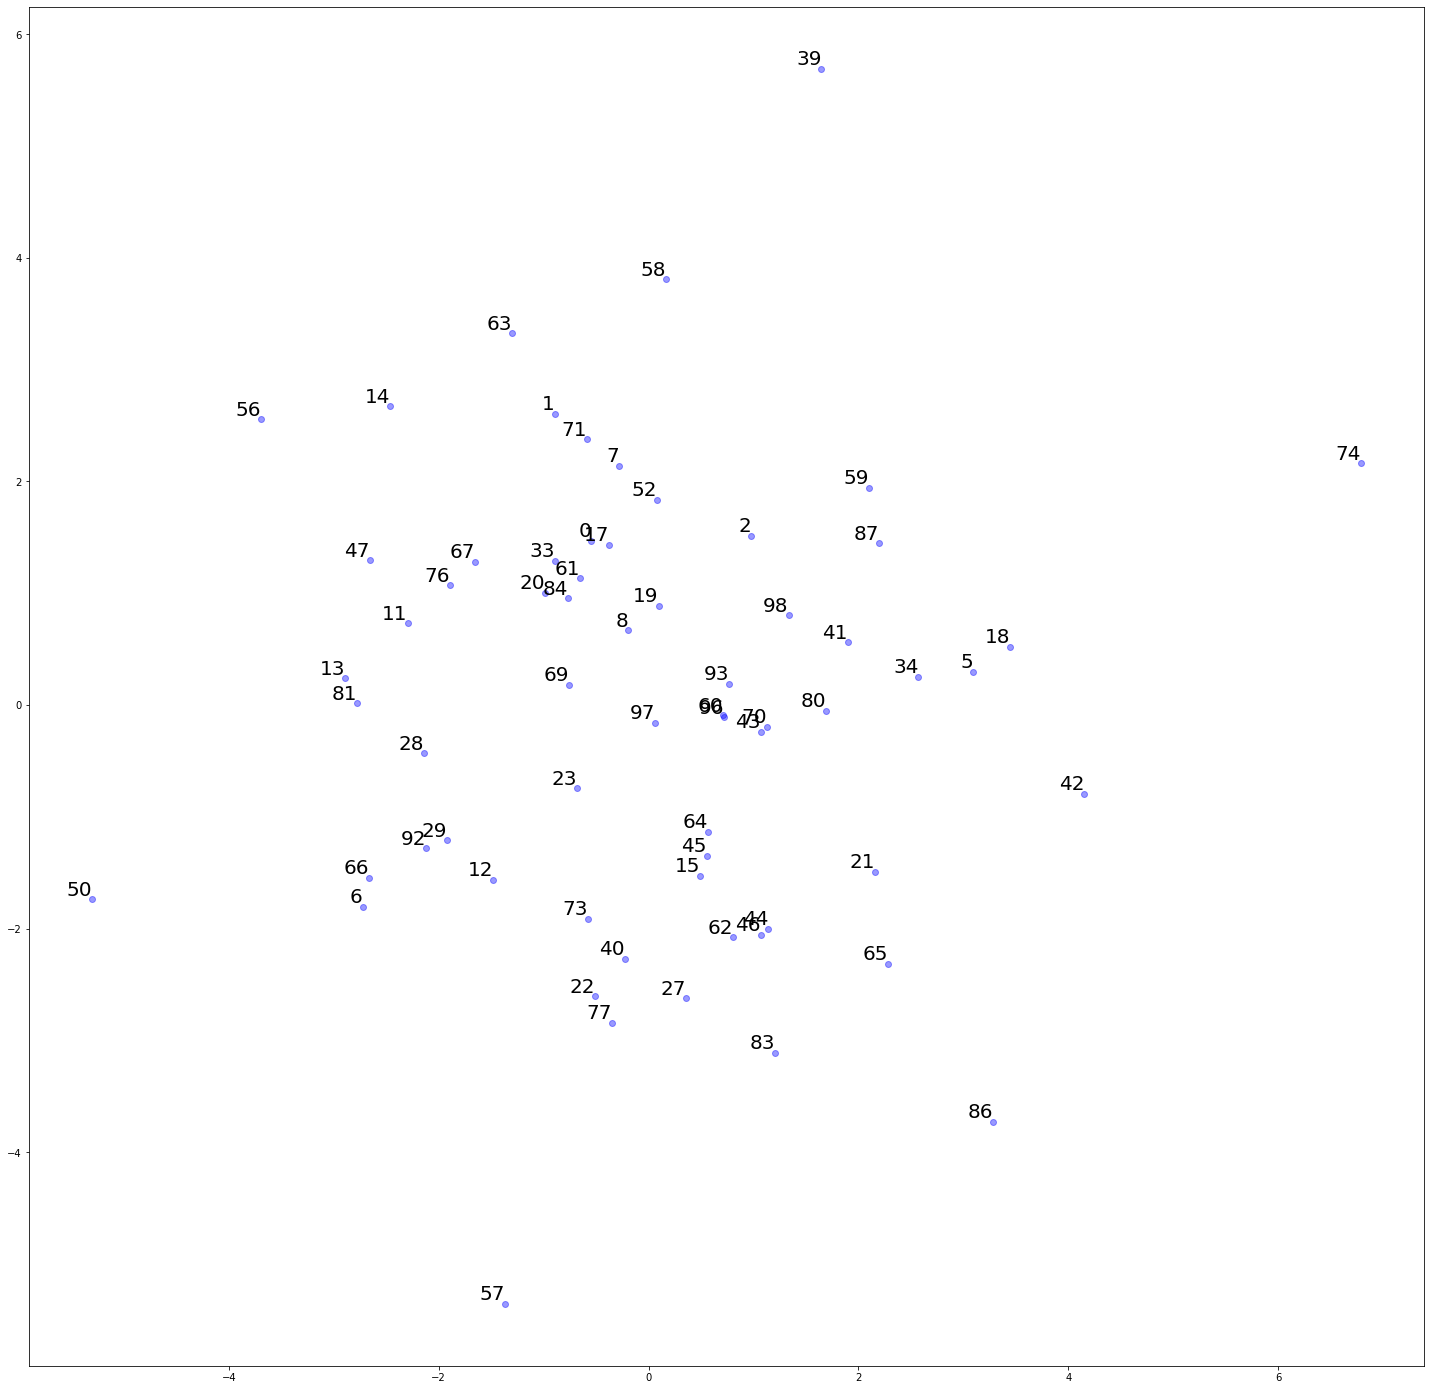

In [24]:
# see the 2D class segments embedding
class_PCA=PCA(n_components=2).fit_transform(EMBEDDINGS)
class_umap=umap.UMAP().fit_transform(EMBEDDINGS)
cluster_number=6
kmeans_best = SpectralClustering(n_clusters=cluster_number).fit_predict(class_PCA)
EMBEDDINGS_np=np.array(EMBEDDINGS)
plt.figure(figsize = (25,25))
for i in range(vocabulary_size):
    # print('vocab_idx: ', vocab_idx)
    plt.scatter(class_PCA[i][0], class_PCA[i][1],color='blue',alpha=0.4)
    plt.annotate(index_to_word[i], xy = (class_PCA[i][0], class_PCA[i][1]), \
        ha='right',va='bottom',fontsize=20)
plt.savefig(output_path+'/'+'w2v1.png')
#color=plt.cm.RdYlBu(kmeans_best[i]/3)
plt.show()

In [25]:

#word_to_cluster={}
#for i in range(cluster_number):
#    word_to_cluster[str(i)]= np.array(np.where(kmeans_best==i)).ravel()+1
#print(word_to_cluster)

##using the histogram method to cluster 



#cluster_corpus=corpus[:]
#for i in range(cluster_number):
#    cluster_lst=list(word_to_cluster[str(i)])
#    for j in range(len(cluster_corpus)):
#        filament=cluster_corpus[j]
#        filament=[i if np.int64(x) in cluster_lst else x for x in filament]
#        cluster_corpus[j]=filament

#filament_cluster_percentage=[]
#for filament in cluster_corpus:
#    filament_lenghth=len(filament)
#    pert=[]
#    for i in range(cluster_number):
#        cluster_per=float(filament.count(i))/filament_lenghth
#        pert.append(cluster_per)
#    filament_cluster_percentage.append(pert)

#histogram clustering
#pca_filaments = PCA(n_components=2).fit_transform(filament_cluster_percentage)
#plt.figure(figsize = (5, 5))
#for i in range(len(cluster_corpus)):
#    plt.scatter(pca_filaments[i][0], pca_filaments[i][1],color='blue')
#plt.savefig("cluster.png")
#plt.show()

# Show Filament Embedding and cluster

In [26]:
# average filament embedding
from scipy import stats
filament_cluster_number=2
average_method=0 # 0 is average, 1 is weight average
filament_score=[]
all_filament_data=[]
filament_variance=[]
for filament in corpus_ignore:
    score=torch.zeros(embedding_size)
    counts=0
    filament_list=[]
    for i in filament:
        if i==0:
            continue
        counts+=1
        filament_list.append(EMBEDDINGS[word_to_index[i]])
    if len(filament_list)==0:
        print('no')
    filament_list=np.array(filament_list)
    if len(filament_list)==1:
        filament_variance.append(float(0))
    else:
        pca=PCA(n_components=1).fit(filament_list)
        filament_variance.append(pca.singular_values_[0])
    mean=filament_list.mean(axis=0)
    all_filament_data.append(filament_list)
    if average_method==0:
        filament_score.append(mean)
    elif average_method==1:
        dim=len(filament_list[0])
        filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T*0)).diagonal()/np.sqrt(np.pi**dim*0.05)
        filament_normalized=filament_normalized/filament_normalized.sum()
        score=filament_normalized @ filament_list
        if counts<=2:
            continue
        filament_score.append(np.array(score))
all_data=filament_score[:]
all_data.extend(EMBEDDINGS_np)
filament_number=len(filament_score)
print(filament_number)
#filament_normalized=np.exp(-0.5*((filament_list-mean) @ (filament_list-mean).T)).diagonal()/np.sqrt(np.pi**dim)

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
D:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:463: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


16727


(array([2886., 3522., 3494., 3107., 2071., 1137.,  363.,  124.,   17.,
           6.]),
 array([ 0.        ,  6.389394  , 12.77878799, 19.16818199, 25.55757599,
        31.94696999, 38.33636398, 44.72575798, 51.11515198, 57.50454597,
        63.89393997]),
 <BarContainer object of 10 artists>)

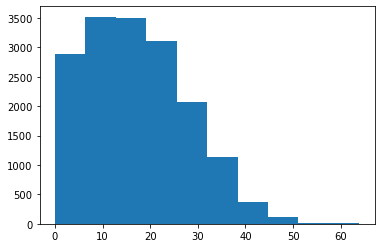

In [27]:
plt.hist(filament_variance)

In [ ]:
# pca_sum = PCA(n_components=2).fit_transform(all_data)
pca_sum_3D = PCA(n_components=3).fit_transform(all_data)
#cluster_pca = KMeans(n_clusters=3).fit_predict(pca_sum[0:len(corpus)])

plt.figure(figsize = (20, 20))
plt.scatter(pca_sum[:,0], pca_sum[:,1],alpha=0.3,color='blue')
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(pca_sum[i+filament_number][0], pca_sum[i+filament_number][1],color='black',marker='*')
    plt.annotate(index_to_word[i], xy = (pca_sum[i+filament_number][0], pca_sum[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_pca.png",bbox_inches='tight', pad_inches=0.01)
plt.show()
# color=plt.cm.RdYlBu(pca_Clustering[i]/4)

## Umap of the filament embedding

In [159]:
n_neighbors=5
min_dist=0.05
reducer = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist)
umap_2D = reducer.fit_transform(all_data)
umap_3D = umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=3).fit_transform(pca_sum_3D)
#filament_umap_ND=umap.UMAP(n_neighbors=n_neighbors,min_dist=min_dist,n_components=50).fit_transform(all_data)[0:filament_number]
filament_umap=umap_2D[0:filament_number]
filament_umap_3D=umap_3D[0:filament_number]


D:\ProgramData\Anaconda3\lib\site-packages\umap\spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"
D:\ProgramData\Anaconda3\lib\site-packages\umap\spectral.py:253: UserWarning: WARNING: spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  "WARNING: spectral initialisation failed! The eigenvector solver\n"


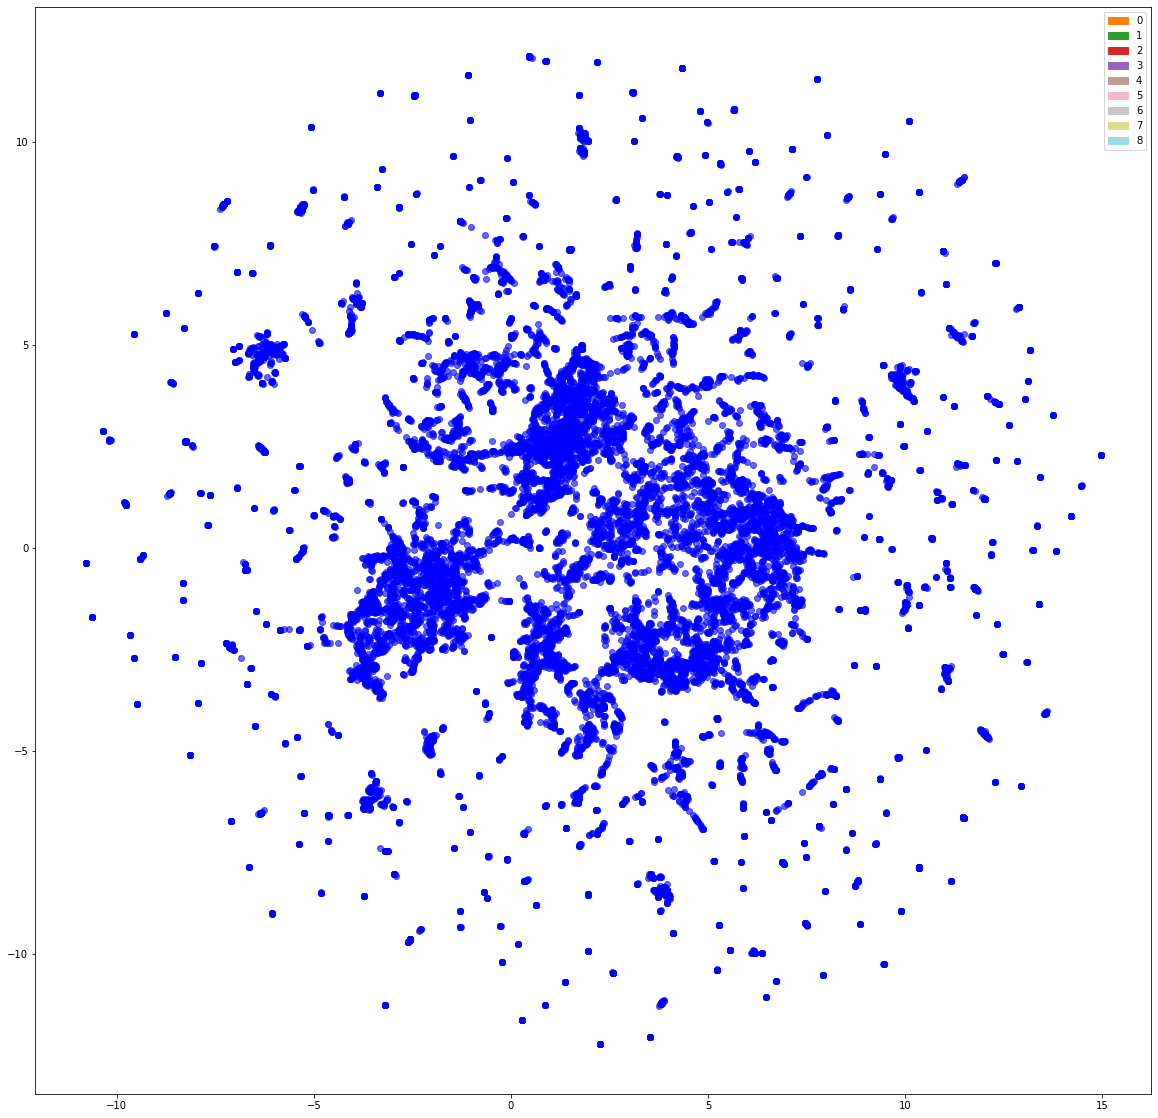

In [160]:
plt.figure(figsize = (20, 20))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color='blue')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.pdf",bbox_inches='tight', pad_inches=0.01)
plt.show()

In [161]:
with open(output_path+'/'+'umap_3D_normal.npy', 'wb') as f:
    np.save(f, filament_umap_3D)
print('finish umap')

finish umap


In [162]:
#filament_cluster_number=2
#umap_predict=KMeans(n_clusters=filament_cluster_number).fit_predict(filament_umap)
#umap_predict =  KMeans(n_clusters=filament_cluster_number).fit_predict(umap[0:filament_number])
#cluster_umap = AgglomerativeClustering(n_clusters=filament_cluster_number,distance_threshold=None).fit(umap[0:filament_number])


umap_predict=DBSCAN(eps=0.5, min_samples=120).fit_predict(filament_umap)+1
filament_cluster_number=len(np.unique(umap_predict))
np.save(output_path+'/'+'umap_predict.npy',umap_predict)
print('finish')

finish


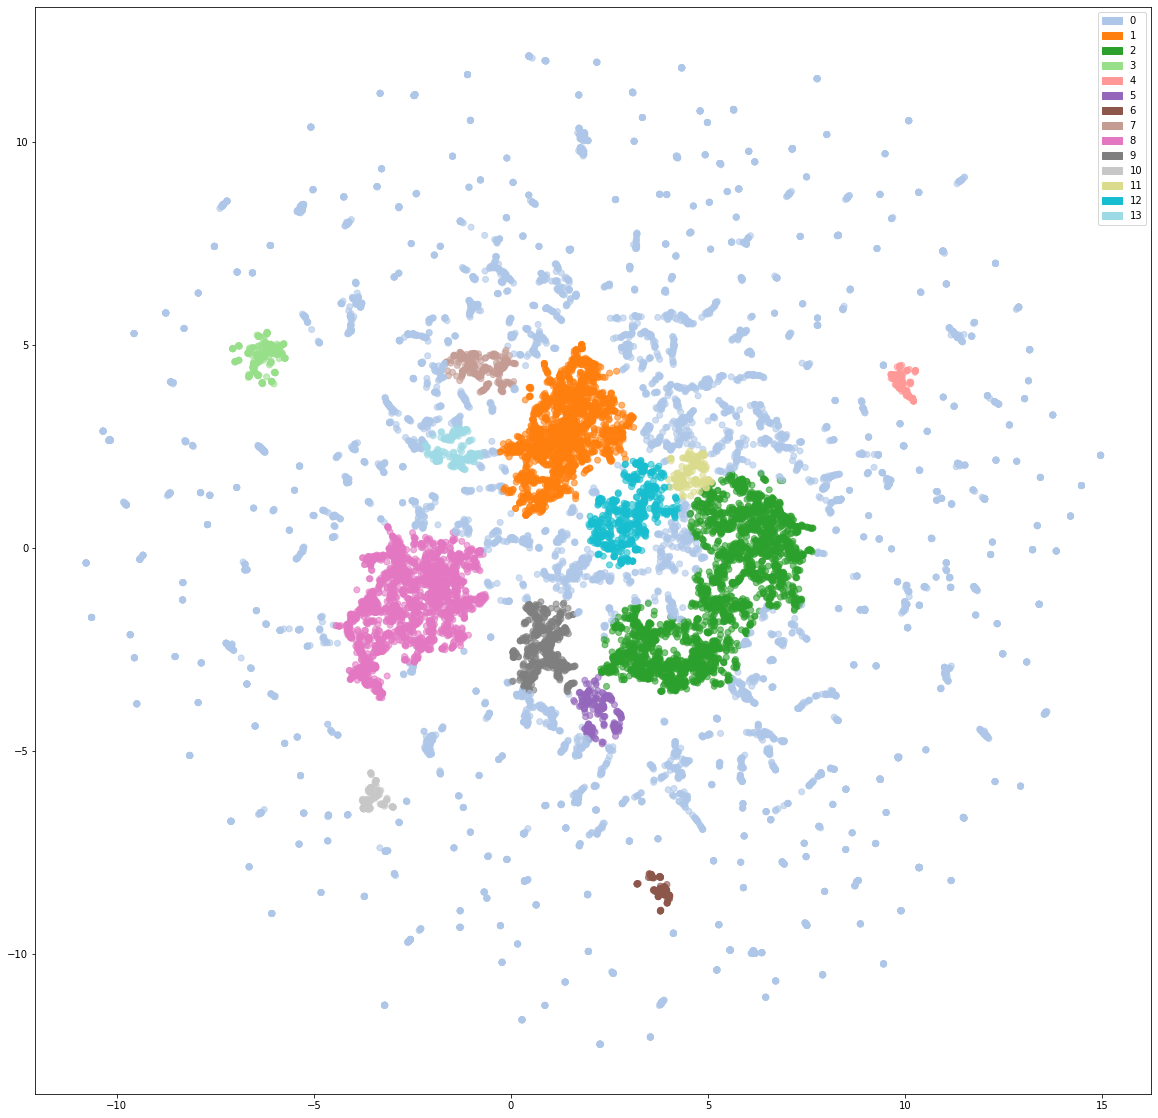

In [163]:
plt.figure(figsize = (20, 20))
for i in range(filament_cluster_number):
    locals()['labels'+str(i)]=mpatches.Patch(color=plt.cm.tab20((i+1)/filament_cluster_number), label=str(i))
plt.legend(handles=[eval('labels'+str(i)) for i in range(filament_cluster_number)])
plt.scatter(filament_umap[:,0], filament_umap[:,1],alpha=0.6,color=plt.cm.tab20((umap_predict+1)/filament_cluster_number))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap.pdf",bbox_inches='tight', pad_inches=0.01)
plt.show()
#color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)

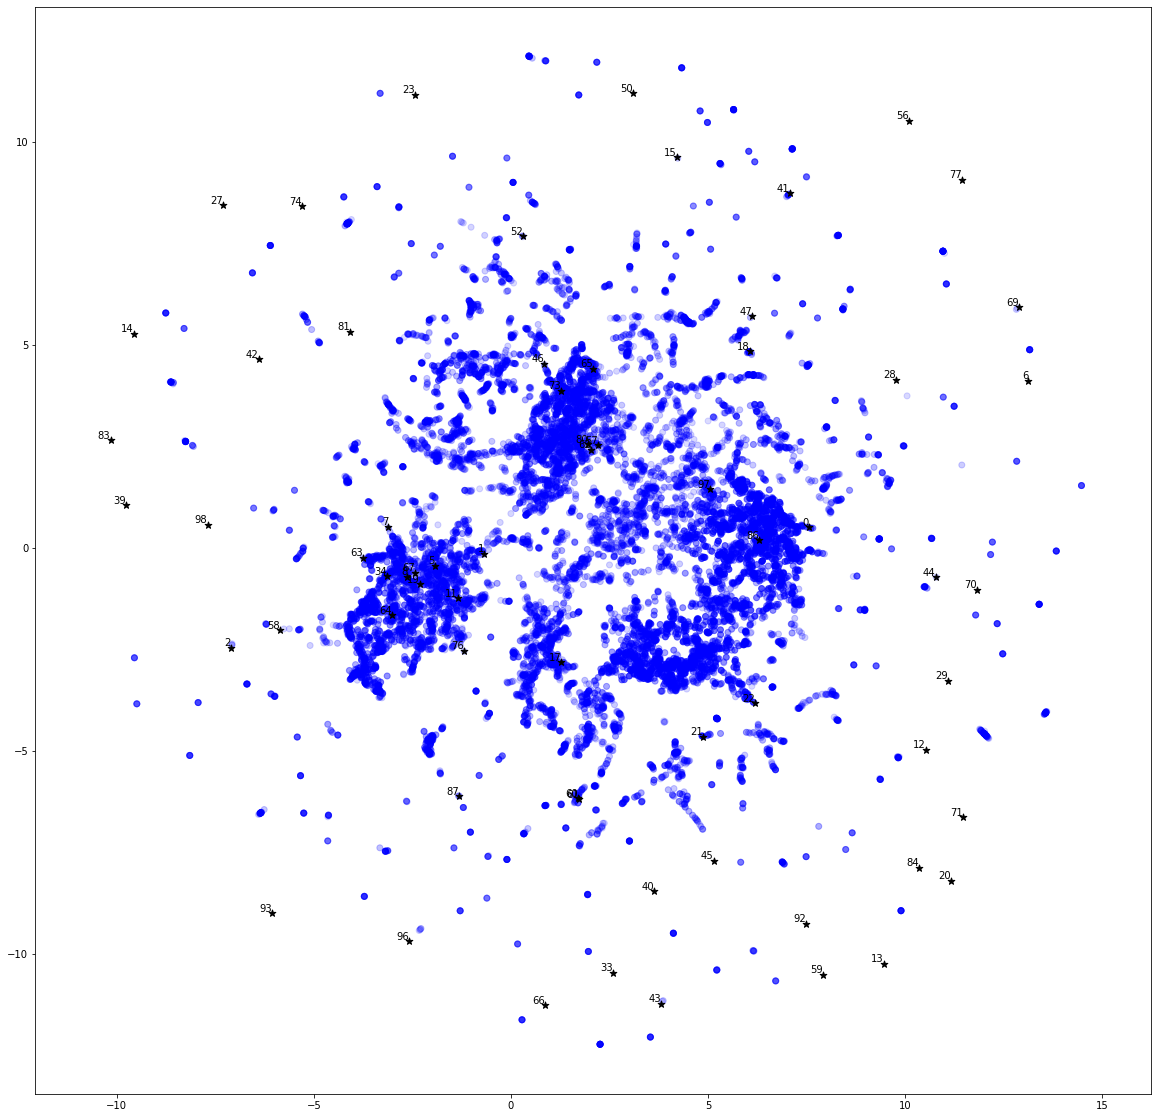

In [164]:
max_c=max(filament_variance)
filament_variance=np.array(filament_variance)
alpha=filament_variance/max_c
alpha_threshold=np.array([0 if a_ <0.1 else a_ for a_ in alpha])
rgba_colors = np.zeros((len(filament_variance),4))
rgba_colors[:,2]=1
rgba_colors[:,3]=alpha_threshold
plt.figure(figsize = (20, 20))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=rgba_colors)
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(umap_2D[i+filament_number][0], umap_2D[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (umap_2D[i+filament_number][0], umap_2D[i+filament_number][1]), ha='right',va='bottom')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue_threshold.pdf",bbox_inches='tight', pad_inches=0.01)
plt.show()

# color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
# color='blue'

In [165]:
def select_area(all_filament_data,all_data_array,filament_index,start,length):
    select_filament_area=all_filament_data[filament_index][start:start+length]
    select_area_mean=select_filament_area.mean(axis=0)
    distance=np.sqrt(np.sum((all_data_array-select_area_mean)**2,axis=1))
    i=np.argmin(distance)
    return i, distance
similar_list=[]
filament_index=11
print(corpus_ignore[filament_index])
for i in range(0,len(all_filament_data[filament_index]),12):
    a, distance=select_area(all_filament_data,filament_score,filament_index,i,7)
    similar_list.append(a)
print(similar_list)

[59]
[11]


In [166]:
#def select_area(filament,length,gap):
#    select_area_all=[]
#    for i in range(0,len(filament),gap):
#        select_area=filament[i:i+length]
#        select_area_mean=select_area.mean(axis=1)
#        select_area_all.append(select_area_mean)
#    select_area_all=np.array(select_area_all)
#    return select_area_all
#data_select_area=select_area(all_filament_data[0],8,2)
#print(data_select_area[0])

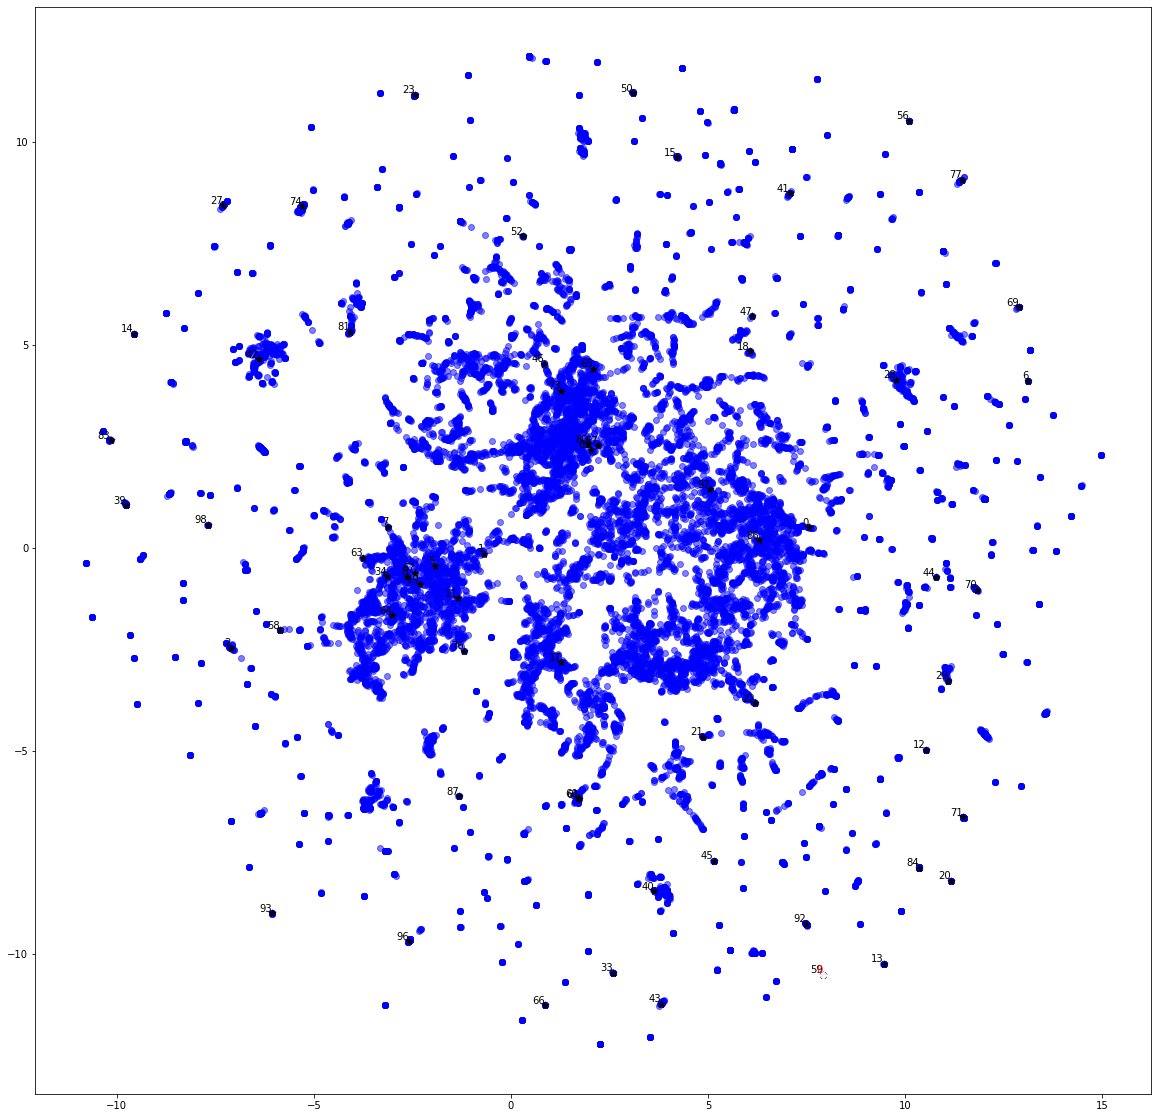

In [167]:
#umap_2D or pca_sum
rd_data=umap_2D
plt.figure(figsize = (20, 20))


plt.scatter(rd_data[:,0], rd_data[:,1],color='blue',alpha=0.5)
for i in range(len(EMBEDDINGS_np)):
    plt.scatter(rd_data[i+filament_number][0], rd_data[i+filament_number][1],color='black',marker='*',s=50)
    plt.annotate(index_to_word[i], xy = (rd_data[i+filament_number][0], rd_data[i+filament_number][1]), ha='right',va='bottom')
for i in range(len(similar_list)):
    plt.scatter(rd_data[similar_list[i],0],rd_data[similar_list[i],1],color=plt.cm.Reds(i/len(similar_list)))
    plt.annotate(i, xy = (rd_data[similar_list[i],0], rd_data[similar_list[i],1]), ha='right',va='bottom',color='red')
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_blue.pdf",bbox_inches='tight', pad_inches=0.01)
plt.show()

# color=plt.cm.tab20((umap_predict+1)/filament_cluster_number)
# color='blue'

## Seperate the clusters

In [168]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    cluster_nameID='clusterID'+str(i)
    locals()[cluster_name]=[]
    locals()[cluster_nameID]=[]
data_line=0
cluster_choice=umap_predict
positive_label=[]
for i in range(len(helix_name)):
    positive_label.append(helix_name[i][11:14])
positive_label=np.array(positive_label)
labels=list(np.unique(positive_label))
positive_label_new=np.array([float(labels.index(x)) for x in positive_label])
labels_name=['1','2','3','4','5'] # define the type of filaments 
clustersize=[]
for i in range(filament_cluster_number):
    clustersize.append(len(locals()['cluster'+str(i)]))
print(positive_label_new[2])

3.0


# Compare with the positive labels

16727 16727
16727


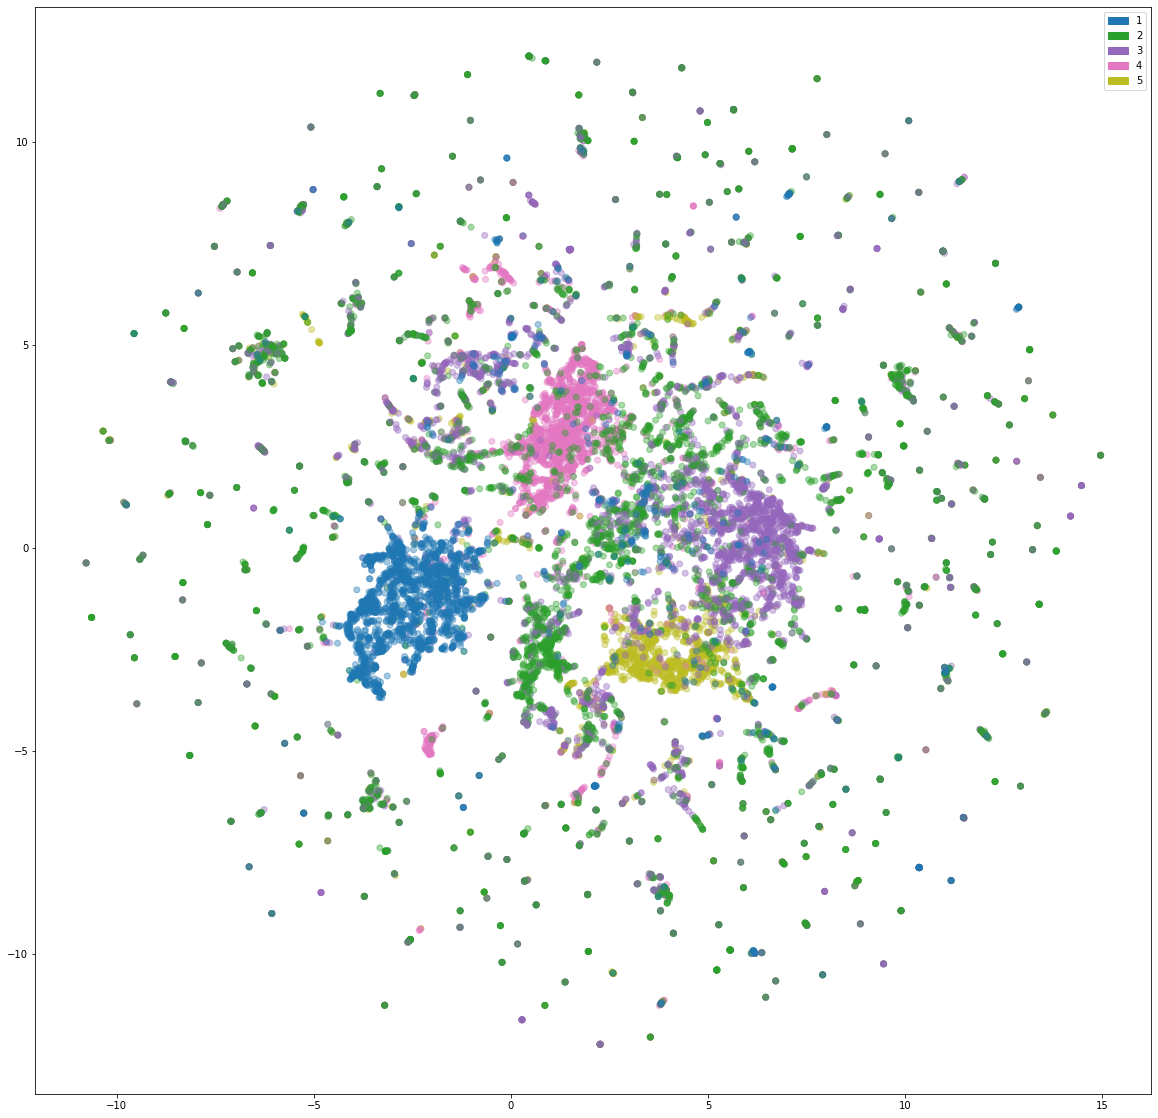

In [169]:
print(len(positive_label_new),len(filament_umap))
plt.figure(figsize = (20, 20))
for i in range(len(labels_name)):
    locals()['true_label'+str(i)]=mpatches.Patch(color=plt.cm.tab20(i/5), label=labels_name[i])
plt.legend(handles=[eval('true_label'+str(i)) for i in range(len(labels))])
print(len(positive_label))
plt.scatter(filament_umap[:,0], filament_umap[:,1],color=plt.cm.tab20(positive_label_new/5),alpha=0.4)
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+"_umap_label.pdf",bbox_inches='tight', pad_inches=0.01)

8213 0
1760 1
948 2
235 3
2033 4
227 5
1326 6
200 7
188 8
533 9
141 10
234 11
167 12
329 13
193 14
[[0.03275295263606477, 0.4423474978692317, 0.2608060392061366, 0.1568245464507488, 0.10726896383781809], [0.005681818181818182, 0.07840909090909091, 0.00909090909090909, 0.897159090909091, 0.009659090909090909], [0.013713080168776372, 0.046413502109704644, 0.07805907172995781, 0.024261603375527425, 0.8375527426160337], [0.01276595744680851, 0.5404255319148936, 0.17446808510638298, 0.0851063829787234, 0.18723404255319148], [0.8745696015740285, 0.04131824889326119, 0.043777668470241025, 0.029513034923757994, 0.010821446138711265], [0.0, 0.14096916299559473, 0.5066079295154186, 0.07048458149779736, 0.28193832599118945], [0.030165912518853696, 0.09502262443438914, 0.8046757164404224, 0.030165912518853696, 0.03996983408748114], [0.005, 0.175, 0.1, 0.07, 0.65], [0.14361702127659576, 0.4308510638297872, 0.30319148936170215, 0.11702127659574468, 0.005319148936170213], [0.0075046904315197, 0.77861

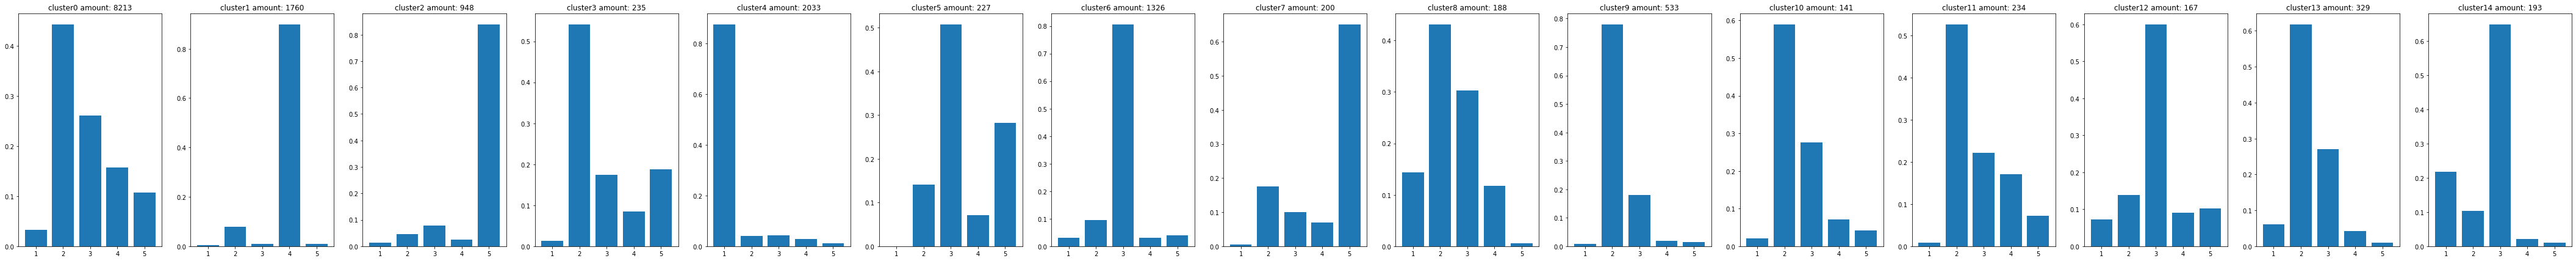

In [139]:
# histogram on rate of successful
hist_data=pd.DataFrame({'labels':positive_label_new,'predict':cluster_choice})
distribution_hist_all=[]
particle_number=[]
for i in range(filament_cluster_number):
    distribution=[]
    lst=hist_data[hist_data['predict']==i]
    particle_number.append(len(lst))
    print(len(lst),i)
    for j in range(len(labels)):
        distribution.append(len(lst[lst['labels']==j])/len(lst))
    distribution_hist_all.append(distribution)
print(distribution_hist_all)
np.save(output_path+'/''class_distribution.npy',distribution_hist_all)
np.save(output_path+'/''particle_number.npy',particle_number)
fig, ax = plt.subplots(1,filament_cluster_number,figsize = (5*filament_cluster_number,7))

for i in range(filament_cluster_number):
    ax[i].bar(range(len(labels)),distribution_hist_all[i],tick_label =labels_name)
    ax[i].set_title('cluster{} amount: {}'.format(i,particle_number[i]))
plt.savefig(output_path+'/'+os.path.splitext(file_name)[0]+'distr_new.pdf')

In [129]:
#seperate cluster
for i in range(filament_cluster_number):
    locals()['cluster'+str(i)]=[]
    locals()['clusterID'+str(i)]=[]
for i in range(len(corpus)):
    labels=umap_predict[i]
    locals()['clusterID'+str(labels)].append(i)
    lst=corpus[i]
    for j in range(len(lst)):
        dataline=lst[j][-1]
        locals()['cluster'+str(labels)].append(data[dataline])

In [130]:
#seperarte subcluster
for i in range(filament_cluster_number):
    cluster=locals()['cluster'+str(i)]
    lst=locals()['clusterID'+str(i)]
    for j in range(filament_cluster_number):
        subcluster_name='cluster'+str(i)+'_'+str(j)
        locals()[subcluster_name]=[x for x, y in zip(cluster,lst) if y==labels[j]]

IndexError: invalid index to scalar variable.

In [ ]:
print(helix_name[0])

# Write .star file for the clusters

In [123]:
for i in range(filament_cluster_number):
    cluster_name='cluster'+str(i)
    data_cluster=locals()[cluster_name]
    if datatype==0:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.opticgroup(optics)
        output.writecluster()
    elif datatype==1:
        output=EMdata.output_star(output_path+'/'+file_name,i,data_cluster,metadata)
        output.writemetadata()
        output.writecluster()

In [ ]:
# write subcluster relion
for i in range(filament_cluster_number):
    for j in range(filament_cluster_number):
        cluster_name='cluster'+str(i)+'_'+str(j)
        data_cluster=locals()[cluster_name]
        if datatype==0:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.opticgroup(optics)
            output.writecluster()
        elif datatype==1:
            output=EMdata.output_star(output_path+'/'+file_name,str(i)+'_'+str(j),data_cluster,metadata)
            output.writemetadata()
            output.writecluster()